# A


In [62]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

df = pd.read_csv("test.csv", sep = "\t", header = None, index_col = 0)

stock = input('Input stock symbol')
close = df.loc[stock]

days = pd.date_range(start='1/5/2007', end ='1/1/2017')
df = pd.DataFrame({'close': close.values}, index = days)

display(df)

print("Number of rows and columns:", df.shape)

split_ind = math.floor(0.8*df.shape[0])
training_set = df.iloc[:split_ind]
test_set = df.iloc[split_ind:]

print(training_set.shape)
print(test_set.shape)

Input stock symbola


,close
2007-01-05,11.144
2007-01-06,10.471
2007-01-07,10.828
2007-01-08,10.698
2007-01-09,10.910
...,...
2016-12-28,68.220
2016-12-29,68.250
2016-12-30,68.110
2016-12-31,67.470


Number of rows and columns: (3650, 1)
(2920, 1)
(730, 1)


In [63]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

TIME_STEPS = 60

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(TIME_STEPS, training_set.shape[0]):
    X_train.append(training_set_scaled[i-TIME_STEPS:i, 0])
    y_train.append(training_set_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print(X_train.shape)
print(y_train.shape)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
print(X_train.shape)
print(y_train.shape)

(2860, 60)
(2860,)
(2860, 60, 1)
(2860,)


In [64]:
model = Sequential()#Adding the first LSTM layer and some Dropout regularisation

model.add(LSTM(units = 50, return_sequences = True, input_shape = (X_train.shape[1], 1)))
model.add(Dropout(0.2))# Adding a second LSTM layer and some Dropout regularisation

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))# Adding a third LSTM layer and some Dropout regularisation

model.add(LSTM(units = 50, return_sequences = True))
model.add(Dropout(0.2))# Adding a fourth LSTM layer and some Dropout regularisation

model.add(LSTM(units = 50))
model.add(Dropout(0.2))# Adding the output layer

model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 10, batch_size = 32)

Epoch 1/10
90/90 [==============================] - 17s 122ms/step - loss: 0.0168
Epoch 2/10
90/90 [==============================] - 11s 120ms/step - loss: 0.0045
Epoch 3/10
90/90 [==============================] - 11s 121ms/step - loss: 0.0044
Epoch 4/10
90/90 [==============================] - 11s 121ms/step - loss: 0.0040
Epoch 5/10
90/90 [==============================] - 11s 120ms/step - loss: 0.0034
Epoch 6/10
90/90 [==============================] - 11s 121ms/step - loss: 0.0035
Epoch 7/10
90/90 [==============================] - 11s 119ms/step - loss: 0.0037
Epoch 8/10
90/90 [==============================] - 11s 121ms/step - loss: 0.0029
Epoch 9/10
90/90 [==============================] - 11s 121ms/step - loss: 0.0026
Epoch 10/10
90/90 [==============================] - 11s 118ms/step - loss: 0.0027


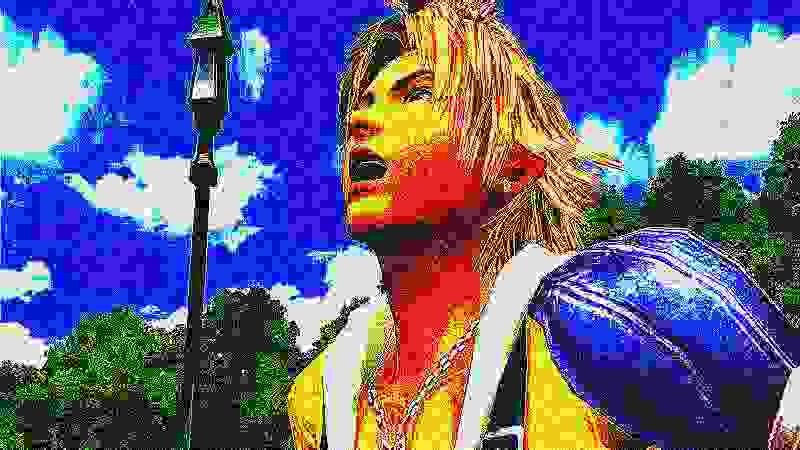

In [65]:
# Using the created model
dataset_train = df.iloc[:split_ind]
dataset_test = df.iloc[split_ind:]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
print(dataset_total.shape)

inputs = dataset_total[len(dataset_total) - len(dataset_test) - TIME_STEPS:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

print(inputs.shape)

X_test = []
for i in range(TIME_STEPS, inputs.shape[0]):
    X_test.append(inputs[i-TIME_STEPS:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

(3650, 1)
(790, 1)
(730, 60, 1)


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


In [66]:
# Get predictions
predicted_stock_price = model.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

print(predicted_stock_price.shape)

(730, 1)


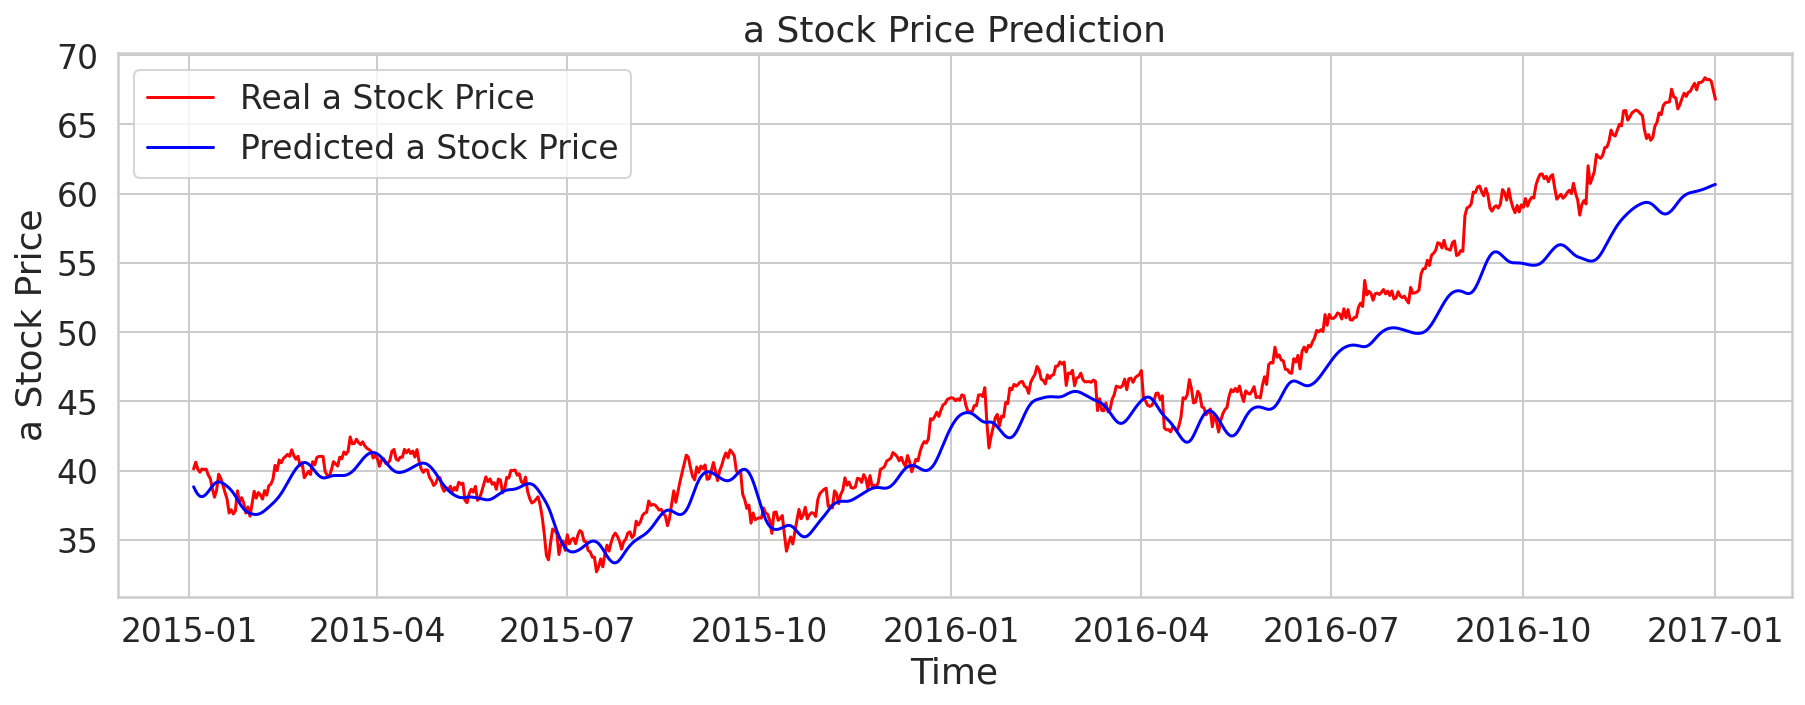

In [67]:
# Visualising the results
plt.figure(figsize=(15, 5))
plt.plot(dataset_test.index, dataset_test['close'], color = 'red', label = 'Real ' + stock + ' Stock Price')
plt.plot(dataset_test.index, predicted_stock_price, color = 'blue', label = 'Predicted ' + stock + ' Stock Price')
plt.title(stock + ' Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel(stock + ' Stock Price')
plt.legend()
plt.show()



---





# B


In [31]:
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

df = pd.read_csv("test.csv", sep = "\t", header = None, index_col = 0)

stock = input('Input stock symbol')
close = df.loc[stock]

days = pd.date_range(start='1/5/2007', end ='1/1/2017')
df = pd.DataFrame({'close': close.values}, index = days)

display(df)

print("Number of rows and columns:", df.shape)

split_ind = math.floor(0.8*df.shape[0])
train = df.iloc[:split_ind]
test = df.iloc[split_ind:]

print(train.shape)
print(test.shape)

Input stock symbola


,close
2007-01-05,11.144
2007-01-06,10.471
2007-01-07,10.828
2007-01-08,10.698
2007-01-09,10.910
...,...
2016-12-28,68.220
2016-12-29,68.250
2016-12-30,68.110
2016-12-31,67.470


Number of rows and columns: (3650, 1)
(2920, 1)
(730, 1)


In [27]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


(2890, 30, 1)


In [33]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_split=0.1,
    shuffle=False
)

Epoch 1/10
82/82 [==============================] - 7s 45ms/step - loss: 0.2539 - val_loss: 0.2690
Epoch 2/10
82/82 [==============================] - 3s 34ms/step - loss: 0.2343 - val_loss: 0.2461
Epoch 3/10
82/82 [==============================] - 3s 34ms/step - loss: 0.2217 - val_loss: 0.2178
Epoch 4/10
82/82 [==============================] - 3s 34ms/step - loss: 0.2045 - val_loss: 0.2139
Epoch 5/10
82/82 [==============================] - 3s 34ms/step - loss: 0.1941 - val_loss: 0.2071
Epoch 6/10
82/82 [==============================] - 3s 37ms/step - loss: 0.1829 - val_loss: 0.1925
Epoch 7/10
82/82 [==============================] - 3s 35ms/step - loss: 0.1782 - val_loss: 0.1865
Epoch 8/10
82/82 [==============================] - 3s 35ms/step - loss: 0.1809 - val_loss: 0.1781
Epoch 9/10
82/82 [==============================] - 3s 36ms/step - loss: 0.1789 - val_loss: 0.1775
Epoch 10/10
82/82 [==============================] - 3s 35ms/step - loss: 0.1712 - val_loss: 0.1738


In [34]:
X_train_pred = model.predict(X_train)

train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)

THRESHOLD = 0.65

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close
anomalies = test_score_df[test_score_df.anomaly == True]

anomalies.head()

,loss,threshold,anomaly,close
2016-07-29,0.654934,0.65,True,3.927188
2016-07-30,0.665885,0.65,True,3.971893
2016-07-31,0.672451,0.65,True,3.893353
2016-08-01,0.682378,0.65,True,3.905583
2016-08-02,0.693368,0.65,True,3.965099


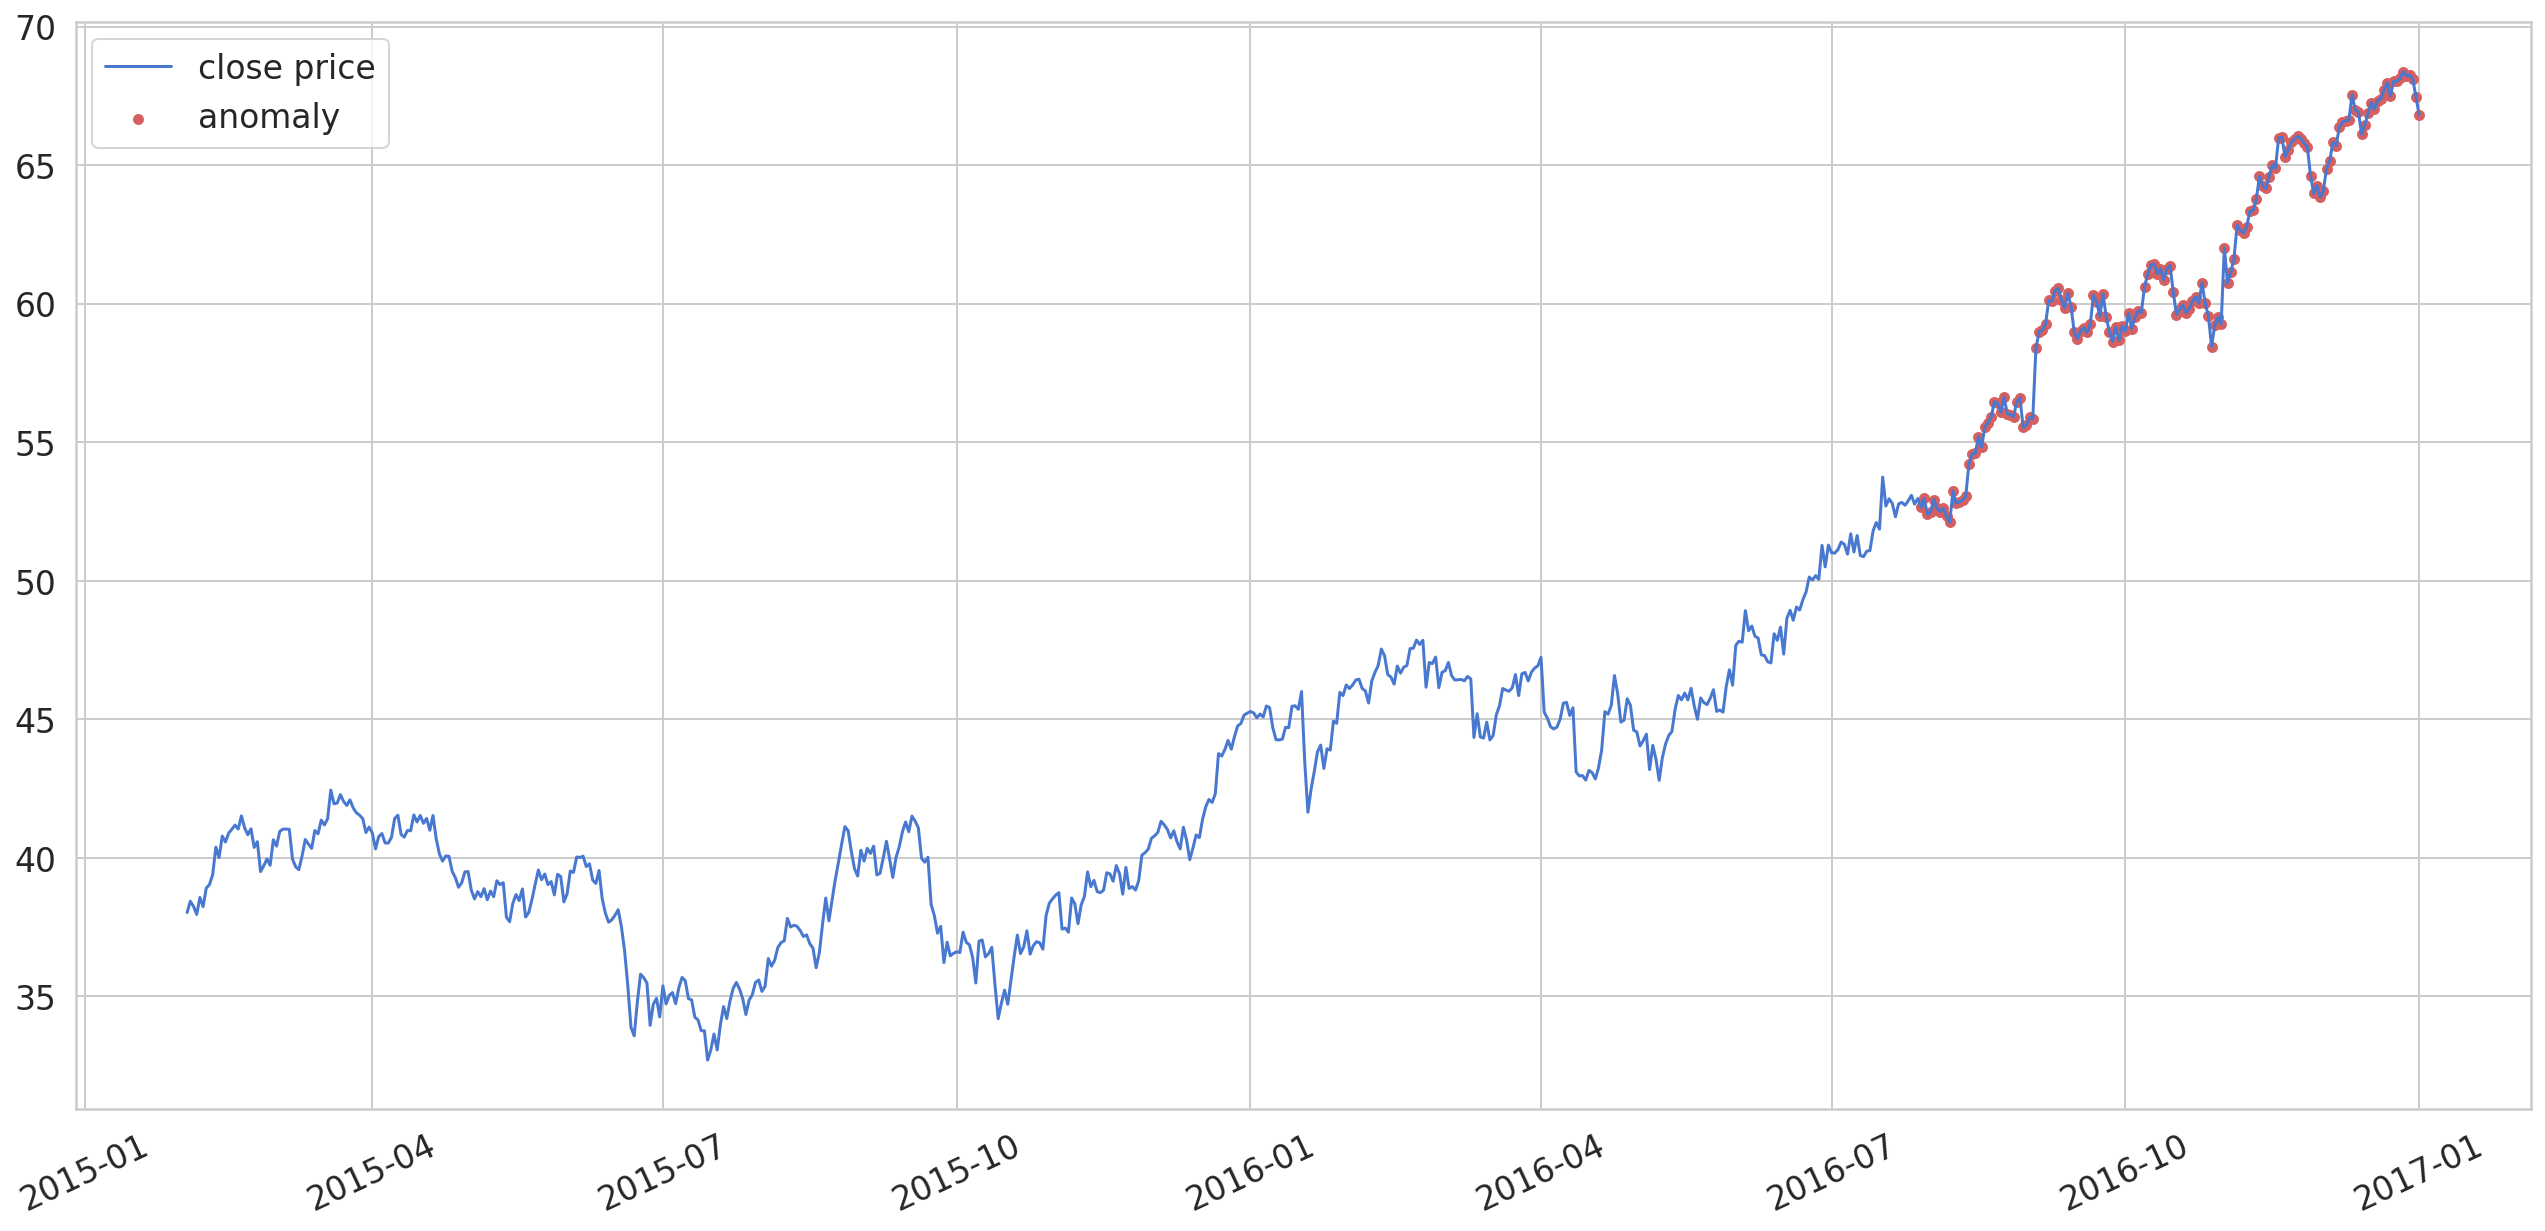

In [35]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close.values.reshape(-1,1)), 
  label='close price'
)

plt.scatter(
  anomalies.index,
  scaler.inverse_transform(anomalies.close.values.reshape(-1,1)),
  color=sns.color_palette()[3],
  s=20,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();

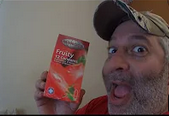